In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
NPRegressionDescription = collections.namedtuple(
    "NPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))

In [3]:
class GPCurvesReader:
    def __init__(self,
                 batch_size,
                 max_num_context,
                 x_size=1,
                 y_size=1,
                 l1_scale=0.6,
                 sigma_scale=1.0,
                 random_kernel_parameters=True,
                 testing=False):
        self.batch_size = batch_size
        self.max_num_context = max_num_context
        self.x_size = x_size
        self.y_size = y_size
        self.l1_scale = l1_scale
        self.sigma_scale = sigma_scale
        self.random_kernel_parameters = random_kernel_parameters
        self.testing = testing
    
    def gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        num_total_points = tf.shape(xdata)[1]
        
        diff = xdata[:, None, :, :] - xdata[:, :, None, :]
        norm = tf.square(diff[:, None, :, :, :] / l1[:, :, None, None, :])
        norm = tf.reduce_sum(norm, -1)
        
        kernel = tf.square(sigma_f)[:, :, None, None] * tf.exp(-0.5 * norm)
        kernel += (sigma_noise ** 2) * tf.eye(num_total_points)
        return kernel

    def generate_curves(self):
        num_context = tf.random_uniform([], 3, self.max_num_context, dtype=tf.int32)
        
        start = -2.
        end = 2.
        if self.testing:
            interval = 1. / 100
            num_target = int((end - start) / interval)
            num_total_points = num_target
            x_values = tf.tile(
                tf.expand_dims(tf.range(start, end, interval, dtype=tf.float32), axis=0),
                [self.batch_size, 1])
            x_values = tf.expand_dims(x_values, axis=-1)
        else:
            num_target = tf.random_uniform([], 0, self.max_num_context - num_context, dtype=tf.int32)
            num_total_points = num_context + num_target
            x_values = tf.random_uniform([self.batch_size, num_total_points, self.x_size], -2, 2)

        param_shape = [self.batch_size, self.y_size, self.x_size]
        if self.random_kernel_parameters:
            l1 = tf.random_uniform(param_shape, 0.1, self.l1_scale)
            sigma_f = tf.random_uniform(param_shape[:-1], 0.1, self.sigma_scale)
        else:
            l1 = tf.ones(param_shape) * self.l1_scale
            sigma_f = tf.ones(param_shape[:-1]) * self.sigma_scale

        kernel = self.gaussian_kernel(x_values, l1, sigma_f)

        cholesky = tf.cast(tf.cholesky(tf.cast(kernel, tf.float64)), tf.float32)

        y_values = tf.matmul(cholesky,
                             tf.random_normal([self.batch_size, self.y_size, num_total_points, 1]))
        y_values = tf.transpose(tf.squeeze(y_values, 3), [0, 2, 1])

        if self.testing:
            target_x = x_values
            target_y = y_values
            
            idx = tf.random_shuffle(tf.range(num_target))
            context_x = tf.gather(x_values, idx[:num_context], axis=1)
            context_y = tf.gather(y_values, idx[:num_context], axis=1)
        else:
            target_x = x_values[:, :num_target + num_context, :]
            target_y = y_values[:, :num_target + num_context, :]
            
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]
        
        query = ((context_x, context_y), target_x)
        return NPRegressionDescription(
            query=query,
            target_y=target_y,
            num_total_points=tf.shape(target_x)[1],
            num_context_points=num_context)

In [4]:
def dense(output_sizes):
    model = tf.keras.Sequential()
    for size in output_sizes[:-1]:
        model.add(tf.keras.layers.Dense(size, activation=tf.nn.relu))
    
    model.add(tf.keras.layers.Dense(output_sizes[-1]))
    return model

In [5]:
def batch_mlp(input_, model):
    batch_size, _, filter_size = input_.shape.as_list()
    output = tf.reshape(input_, (-1, filter_size))
    output.set_shape((None, filter_size))

    output = model(output)
    output_size = output.shape[-1].value

    output = tf.reshape(output, (batch_size, -1, output_size))
    return output

In [6]:
class DeterministicEncoder:
    def __init__(self, output_sizes, attention):
        self.model = dense(output_sizes)
        self.attention = attention

    def __call__(self, context_x, context_y, target_x):
        encoder_input = tf.concat([context_x, context_y], axis=-1)
        hidden = batch_mlp(encoder_input, self.model)
        hidden = self.attention(context_x, target_x, hidden)
        return hidden

In [7]:
class LatentEncoder:
    def __init__(self, output_sizes, num_latents):
        self.model = dense(output_sizes)
        self.penultimate = tf.keras.layers.Dense((output_sizes[-1] + num_latents) / 2)
        self.dense_mu = tf.keras.layers.Dense(num_latents)
        self.dense_sigma = tf.keras.layers.Dense(num_latents)

    def __call__(self, x, y):
        encoder_input = tf.concat([x, y], axis=-1)
        hidden = batch_mlp(encoder_input, self.model)
        hidden = tf.reduce_mean(hidden, axis=1)

        hidden = tf.nn.relu(self.penultimate(hidden))

        mu = self.dense_mu(hidden)
        log_sigma = self.dense_sigma(hidden)
        
        sigma = 0.1 + 0.9 * tf.sigmoid(log_sigma)
        return tfp.distributions.Normal(loc=mu, scale=sigma)

In [8]:
class Decoder:
    def __init__(self, output_sizes):
        self.model = dense(output_sizes)

    def __call__(self, context, target_x):
        hidden = tf.concat([context, target_x], axis=-1)
        hidden = batch_mlp(hidden, self.model)

        mu, log_sigma = tf.split(hidden, 2, axis=-1)
        sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

        dist = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)        
        return dist, mu, sigma

In [ ]:
class LatentModel:
    def __init__(self,
                 latent_encoder_output_sizes,
                 num_latents,
                 decoder_output_sizes,
                 use_deterministic_path=True,
                 deterministic_encoder_output_sizes=None,
                 attention=None):
        self.latent_encoder = LatentEncoder(latent_encoder_output_sizes, num_latents)
        self.decoder = Decoder(decoder_output_sizes)
        self.use_deterministic_path = use_deterministic_path
        if use_deterministic_path:
            self.deterministic_encoder = DeterministicEncoder(
                deterministic_encoder_output_sizes, attention)

    def __call__(self, query, num_targets, target_y=None):
        (context_x, context_y), target_x = query
        prior = self.latent_encoder(context_x, context_y)

        if target_y is None:
            latent_rep = prior.sample()
        else:
            posterior = self.latent_encoder(target_x, target_y)
            latent_rep = posterior.sample()

        latent_rep = tf.tile(tf.expand_dims(latent_rep, axis=1),
                             [1, num_targets, 1])
        if self.use_deterministic_path:
            deterministic_rep = self.deterministic_encoder(context_x, context_y, target_x)
            context = tf.concat([deterministic_rep, latent_rep], axis=-1)
        else:
            context = latent_rep

        dist, mu, sigma = self.decoder(context, target_x)
        if target_y is not None:
            log_p = dist.log_prob(target_y)
            posterior = self.latent_encoder(target_x, target_y)
            
            kl = tf.reduce_sum(tfp.distributions.kl_divergence(posterior, prior), axis=-1, keepdims=True)
            kl = tf.tile(kl, [1, num_targets])
            loss = -tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
        else:
            log_p = None
            kl = None
            loss = None

        return mu, sigma, log_p, kl, loss

In [ ]:
def uniform_attention(q, v):
    total_points = tf.shape(q)[1]
    rep = tf.reduce_mean(v, axis=1, keepdims=True)
    rep = tf.tile(rep, [1, total_points, 1])
    return rep

def laplace_attention(q, k, v, scale, normalise):
    k = tf.expand_dims(k, axis=1)
    q = tf.expand_dims(q, axis=2)
    unnorm_weights = -tf.abs((k - q) / scale)
    unnorm_weights = tf.reduce_sum(unnorm_weights, axis=-1)
    if normalise:
        weight_fn = tf.nn.softmax
    else:
        weight_fn = lambda x: 1 + tf.tanh(x)
    weights = weight_fn(unnorm_weights)
    rep = tf.einsum('bik,bkj->bij', weights, v)
    return rep

def dot_product_attention(q, k, v, normalise):
    d_k = tf.shape(q)[-1]
    scale = tf.sqrt(tf.cast(d_k, tf.float32))
    unnorm_weights = tf.einsum('bjk,bik->bij', k, q) / scale
    if normalise:
        weight_fn = tf.nn.softmax
    else:
        weight_fn = tf.sigmoid
    weights = weight_fn(unnorm_weights)
    rep = tf.einsum('bik,bkj->bij', weights, v)
    return rep

class MultiheadAttention:
    def __init__(num_heads):
        self.num_heads = num_heads
        self.params = None
    
    def get_params(self, d_k, d_v):
        params = []
        head_size = d_v / self.num_heads
        key_initializer = tf.random_normal_initializer(stddev=d_k ** -0.5)
        value_initializer = tf.random_normal_initializer(stddev=d_v ** -0.5)
        for _ in range(num_heads):
            param = {}
            param['conv_q'] = tf.keras.layers.Conv1D(head_size, 1, padding='VALID', use_bias=False, kernel_initializer=key_initializer)
            param['conv_k'] = tf.keras.layers.Conv1D(head_size, 1, padding='VALID', use_bias=False, kernel_initializer=key_initializer)
            param['conv_v'] = tf.keras.layers.Conv1D(head_size, 1, padding='VALID', use_bias=False, kernel_initializer=key_initializer)
            param['conv_o'] = tf.keras.layers.Conv1D(d_v, 1, padding='VALID', use_bias=False, kernel_initializer=value_initializer)
            params.append(param)

        return params

    def __call__(self, q, k, v):
        if self.params is None:
            d_k = q.get_shape().as_list()[-1]
            d_v = v.get_shape().as_list()[-1]
            
            self.params = self.get_params(d_k, d_v)
        
        rep = tf.constant(0.)
        for param in self.params:
            conv_q = param['conv_q']
            conv_k = param['conv_k']
            conv_v = param['conv_v']
            conv_o = param['conv_o']
            o = dot_product_attention(conv_q(q), conv_k(k), conv_v(v), normalise=True)
            rep += conv_o(o)

        return rep

class Attention:
    def __init__(self, rep, output_sizes, att_type, scale=1., normalise=True, num_heads=8):
        self.rep = rep
        self.att_type = att_type
        self.scale = scale
        self.normalise = normalise
        if self.rep == 'mlp':
            self.dense_k = dense(output_sizes)
            self.dense_q = dense(output_sizes)
            self.output_size = ouput_sizes[-1]
        if self.att_type == 'multihead':
            self.multihead_attention = MultiheadAttention(num_heads)
    
    def __call__(self, x1, x2, r):
        if self.rep == 'identity':
            k, q = (x1, x2)
        elif self.rep == 'mlp':
            k = batch_mlp(x1, self.dense_k)
            q = batch_mlp(x2, self.dense_q)
        else:
            raise NameError("'rep' not among ['identity', 'mlp']")
        
        if self.att_type == 'uniform':
            rep = uniform_attention(q, r)
        elif self.att_type == 'laplace':
            rep = laplace_attention(q, k, r, self.scale, self.normalise)
        elif self.att_type == 'dot_product':
            rep = dot_product_attention(q, k, r, self.normalise)
        elif self.att_type == 'multihead':
            rep = self.multihead_attention(q, k, r)
        else:
            raise NameError("'att_type' not among ['uniform', 'laplace', 'dot_product', 'multihead']")
        return rep

In [ ]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std):
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
    plt.fill_between(
        target_x[0, :, 0],
        pred_y[0, :, 0] - std[0, :, 0],
        pred_y[0, :, 0] + std[0, :, 0],
        alpha=0.2,
        facecolor='#65c9f7',
        interpolate=True)
    
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid('off')
    plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Iteration: 0, loss: 1.2460260391235352


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


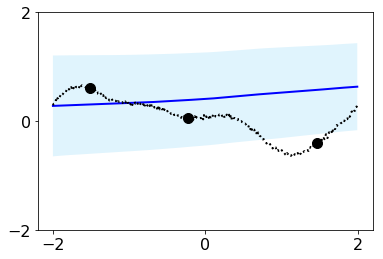

Iteration: 10000, loss: 0.26244333386421204


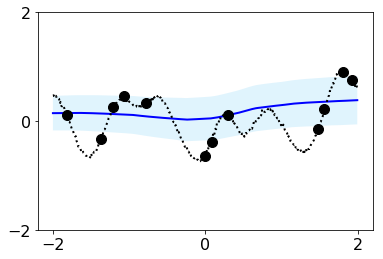

Iteration: 20000, loss: 0.2988204061985016


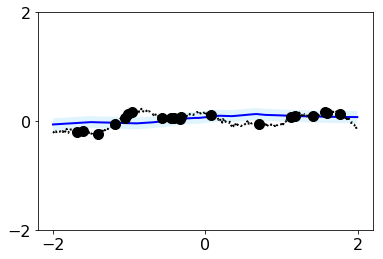

Iteration: 30000, loss: 0.10457718372344971


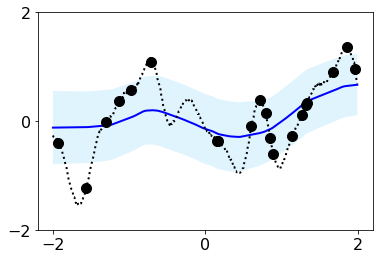

Iteration: 40000, loss: 0.4053608775138855


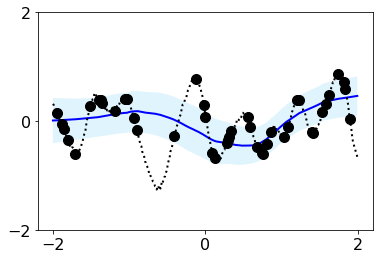

Iteration: 50000, loss: 0.09622685611248016


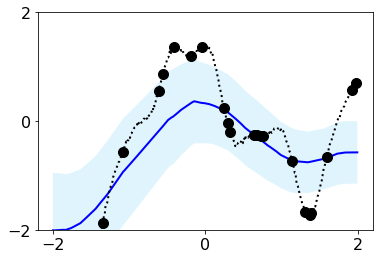

Iteration: 60000, loss: 0.011227552779018879


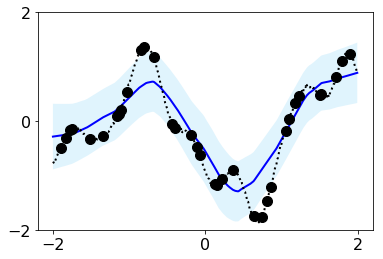

In [ ]:
TRAINING_ITERATIONS = 100000
MAX_CONTEXT_POINTS = 50
PLOT_AFTER = 10000
HIDDEN_SIZE = 128
MODEL_TYPE = 'NP'
ATTENTION_TYPE = 'uniform'

random_kernel_parameters=True

tf.reset_default_graph()

dataset_train = GPCurvesReader(batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)
data_train = dataset_train.generate_curves()

dataset_test = GPCurvesReader(batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)
data_test = dataset_test.generate_curves()

latent_encoder_output_sizes = [HIDDEN_SIZE] * 4
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes = [HIDDEN_SIZE] * 4
decoder_output_sizes = [HIDDEN_SIZE] * 2 + [2]
use_deterministic_path = True

if MODEL_TYPE == 'ANP':
    attention = Attention(rep='mlp', output_sizes=[HIDDEN_SIZE] * 2, att_type=ATTENTION_TYPE)
elif MODEL_TYPE == 'NP':
    attention = Attention(rep='identity', output_sizes=None, att_type='uniform')
else:
    raise NameError("MODEL_TYPE not among ['ANP', 'NP']")

model = LatentModel(latent_encoder_output_sizes,
                    num_latents,
                    decoder_output_sizes,
                    use_deterministic_path,
                    deterministic_encoder_output_sizes,
                    attention)

_, _, log_prob, _, loss = model(data_train.query, data_train.num_total_points, data_train.target_y)

mu, sigma, _, _, _ = model(data_test.query, data_test.num_total_points)

optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for i in range(TRAINING_ITERATIONS):
        sess.run(train_step)
        
        if i % PLOT_AFTER == 0:
            loss_value, pred_y, std_y, target_y, whole_query = sess.run([loss, mu, sigma, data_test.target_y, data_test.query])
            (context_x, context_y), target_x = whole_query
            print('Iteration: {}, loss: {}'.format(i, loss_value))

            plot_functions(target_x, target_y, context_x, context_y, pred_y, std_y)

In [ ]:
TRAINING_ITERATIONS = 100000
MAX_CONTEXT_POINTS = 50
PLOT_AFTER = 10000
HIDDEN_SIZE = 128
MODEL_TYPE = 'ANP'
ATTENTION_TYPE = 'multihead'

random_kernel_parameters=True

tf.reset_default_graph()

dataset_train = GPCurvesReader(batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)
data_train = dataset_train.generate_curves()

dataset_test = GPCurvesReader(batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)
data_test = dataset_test.generate_curves()

latent_encoder_output_sizes = [HIDDEN_SIZE] * 4
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes = [HIDDEN_SIZE] * 4
decoder_output_sizes = [HIDDEN_SIZE] * 2 + [2]
use_deterministic_path = True

if MODEL_TYPE == 'ANP':
    attention = Attention(rep='mlp', output_sizes=[HIDDEN_SIZE] * 2, att_type=ATTENTION_TYPE)
elif MODEL_TYPE == 'NP':
    attention = Attention(rep='identity', output_sizes=None, att_type='uniform')
else:
    raise NameError("MODEL_TYPE not among ['ANP', 'NP']")

model = LatentModel(latent_encoder_output_sizes,
                    num_latents,
                    decoder_output_sizes,
                    use_deterministic_path,
                    deterministic_encoder_output_sizes,
                    attention)

_, _, log_prob, _, loss = model(data_train.query, data_train.num_total_points, data_train.target_y)

mu, sigma, _, _, _ = model(data_test.query, data_test.num_total_points)

optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for i in range(TRAINING_ITERATIONS):
        sess.run(train_step)
        
        if i % PLOT_AFTER == 0:
            loss_value, pred_y, std_y, target_y, whole_query = sess.run([loss, mu, sigma, data_test.target_y, data_test.query])
            (context_x, context_y), target_x = whole_query
            print('Iteration: {}, loss: {}'.format(i, loss_value))
            
            plot_functions(target_x, target_y, context_x, context_y, pred_y, std_y)